#Dragon Ball Data Exploration


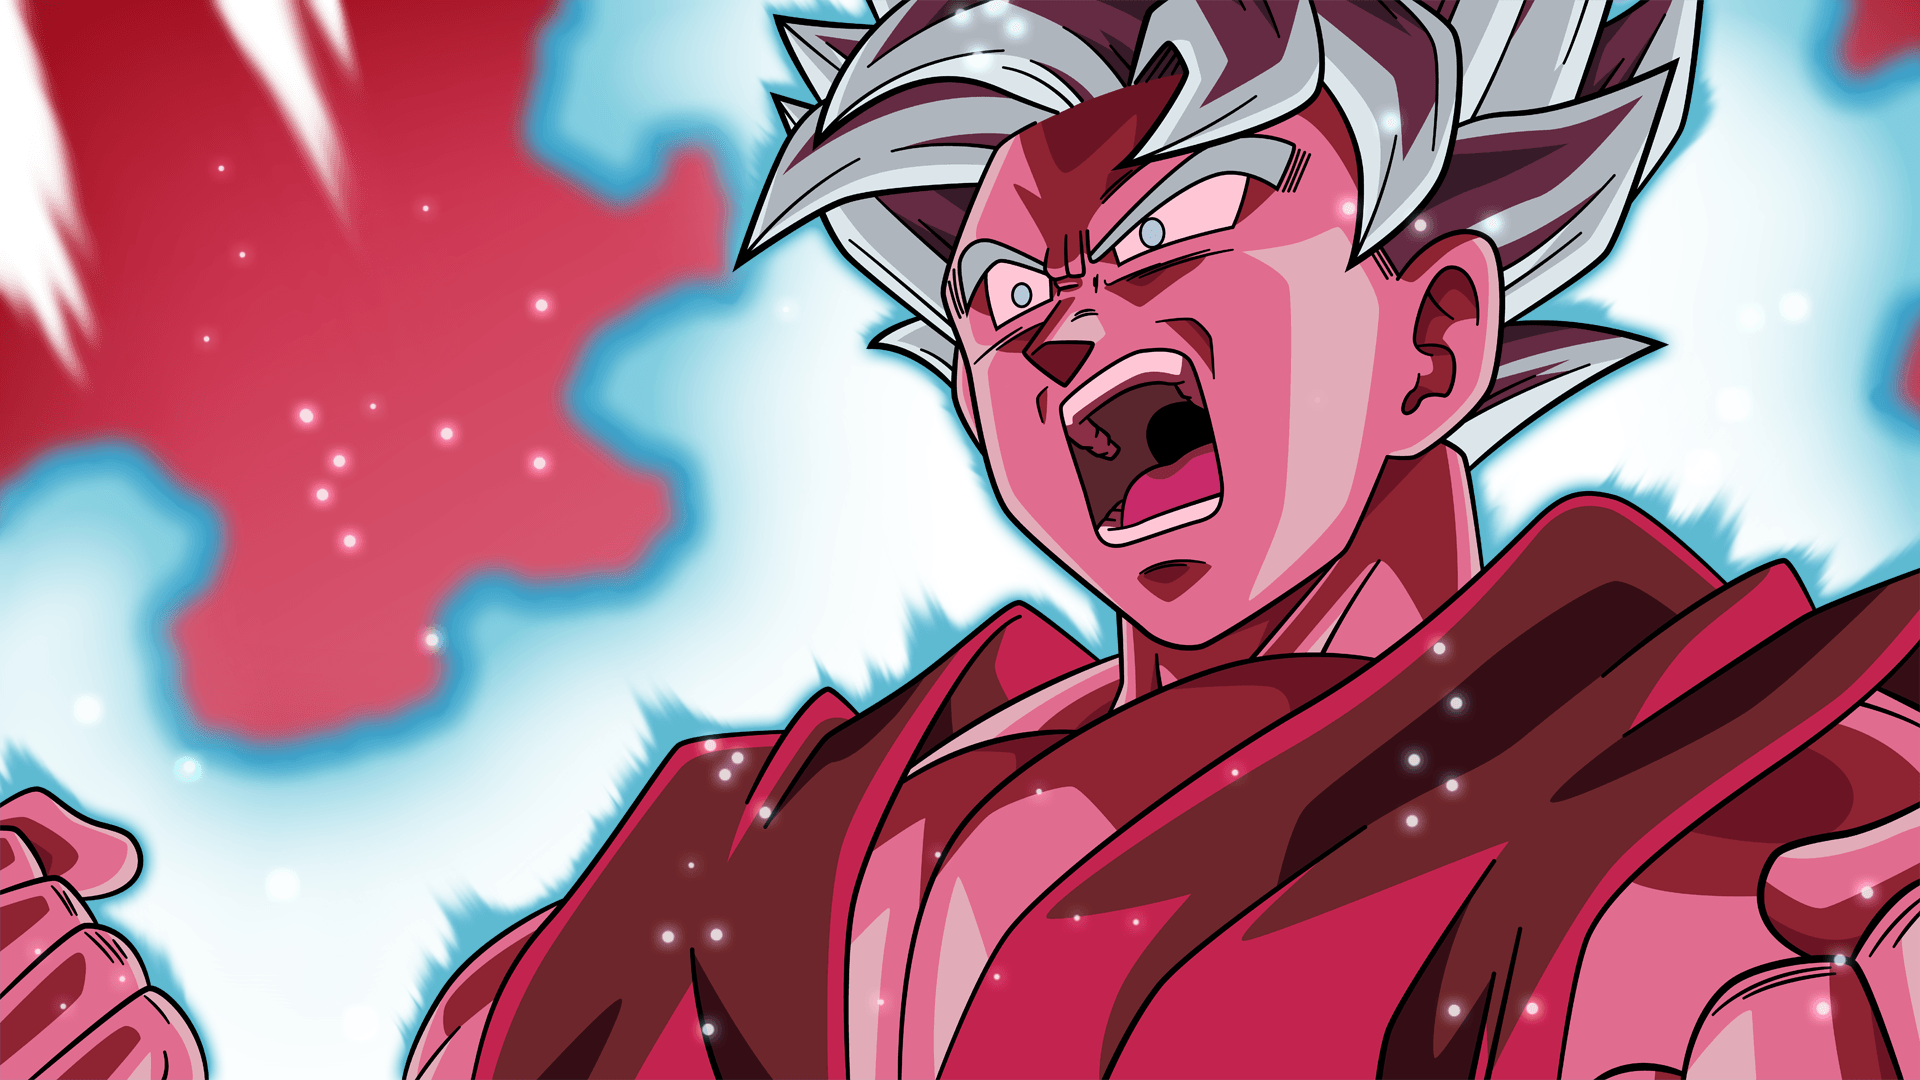

## Initial setup
Import all of the necessary libraries and load the dataset.

In [1]:
#pip install missingno

In [2]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Change the path to your own path
path = "/content/drive/My Drive/Colab Notebooks/Practice/Datasets/"
# Load the file - add the file's name
data = pd.read_csv(path+"Dragon_Ball_Data_Set.csv")

In [5]:
# Rename columns for conventions
dict = {
    'Character': 'Name',
    'Power_Level': 'Power Level',
    'Saga_or_Movie': 'Saga / Movie',
    'Dragon_Ball_Series': 'Series'
}
data.rename(columns=dict, inplace=True)

##Inspect original meta data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          1244 non-null   object
 1   Power Level   1244 non-null   object
 2   Saga / Movie  1244 non-null   object
 3   Series        1244 non-null   object
dtypes: object(4)
memory usage: 39.0+ KB


Lets check if the data has duplicates or not.

In [7]:
# Before removing duplicates
print("Data shape before removing duplicates:\t", data.shape)

data.drop_duplicates()

# After removing duplicates
print("Data shape after removing duplicates:\t", data.shape)

Data shape before removing duplicates:	 (1244, 4)
Data shape after removing duplicates:	 (1244, 4)


## Creating columns

### Canon
Lets consider Dragon Ball and Dragon Ball Z series canon and Dragon Ball GT and Dragon Ball movies non canon

In [8]:
data['Canon'] = np.where(data['Saga / Movie'].str.contains("movie", case = False) | 
                         data['Series'].str.contains("Dragon Ball GT", case = False) | 
                         (np.logical_not(data['Saga / Movie'].str.contains("saga", case = False)) & 
                          np.logical_not(data['Saga / Movie'].str.contains("Goku And Gohan in The Hyperbolic Time Chamber", case = False))), False, True)

Display all of the Sagas that are considered canon

In [9]:
canon = data[data['Canon'] == True]
canon['Saga / Movie'].unique()

array(['Emperor Pilaf Saga', 'Tournament Saga', 'Red Ribbon Army Saga',
       'Fortune Teller Baba Saga', 'Tien Shinhan Saga',
       'King Piccolo Saga', 'Piccolo Jr. Saga', 'Saiyan Saga',
       'Namek Saga', 'Ginyu Force Saga', 'Captain Ginyu Saga',
       'Frieza Saga', 'Trunks Saga', 'Android Saga',
       'Imperfect Cell Saga', 'Perfect Cell Saga',
       'Goku And Gohan in The Hyperbolic Time Chamber', 'Cell Games Saga',
       'Great Saiyaman Saga/World Tournament Saga',
       'Babidi Saga/Majin Buu Saga', 'Fusion Saga', 'Kid Buu Saga'],
      dtype=object)

###Form
Text in round brackets gives more information about the character's current form when the power level is measured. Lets make a column with that information

In [10]:
# Extract text from round brackets into own column
forms = data['Name'].str.extract(".*\s\((.*)\).*", expand=True)

# NaN values mean that form they are in is their basic one
forms = forms.replace(np.NaN, 'Basic')

# Add column to the Dataframe
data.insert(1, 'Form', forms)
data

,Name,Form,Power Level,Saga / Movie,Series,Canon
0,Goku,Basic,10,Emperor Pilaf Saga,Dragon Ball,True
1,Bulma,Basic,1.5,Emperor Pilaf Saga,Dragon Ball,True
2,Bear Thief,Basic,7,Emperor Pilaf Saga,Dragon Ball,True
3,Master Roshi,Basic,30,Emperor Pilaf Saga,Dragon Ball,True
4,Oolong,Basic,5,Emperor Pilaf Saga,Dragon Ball,True
...,...,...,...,...,...,...
1239,Goku (MSSJ with SSJG's power),MSSJ with SSJG's power,"22,400,000,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False
1240,Goku (SSJG),SSJG,"224,000,000,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False
1241,Goku,Basic,"44,800,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False
1242,"Beerus (full power, never shown)","full power, never shown","896,000,000,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False


However the form is still in the name. Lets remove the text and round brackets

In [11]:
# If the current name has left and right round bracket return the part before the round brackets, otherwise return the whole string
data['Name'] = data['Name'].map(lambda x: re.search("(.*)\s\(.*\).*", x).group(1) if('(' in x and ')' in x) else x)
data

,Name,Form,Power Level,Saga / Movie,Series,Canon
0,Goku,Basic,10,Emperor Pilaf Saga,Dragon Ball,True
1,Bulma,Basic,1.5,Emperor Pilaf Saga,Dragon Ball,True
2,Bear Thief,Basic,7,Emperor Pilaf Saga,Dragon Ball,True
3,Master Roshi,Basic,30,Emperor Pilaf Saga,Dragon Ball,True
4,Oolong,Basic,5,Emperor Pilaf Saga,Dragon Ball,True
...,...,...,...,...,...,...
1239,Goku,MSSJ with SSJG's power,"22,400,000,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False
1240,Goku,SSJG,"224,000,000,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False
1241,Goku,Basic,"44,800,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False
1242,Beerus,"full power, never shown","896,000,000,000,000",Movie 14: Battle of Gods,Dragon Ball Z,False


##Highest power level for every saga / movie
Lets see who are the strongest fighers for every Saga / Movie - it can be canon and non canon.

###Fixing Power Levels
Change the type of the Power Level column form object to number so power levels can be compared.

Lets see if there are any numbers with decimal pointers.
The `,` symbol separates numbers so it is easier to be read and the `.` symbol indicates that the number is decimal. We will **round down** decimal power levels. 

In [12]:
# Remove commas between numbers
data['Power Level'] = data['Power Level'].str.replace(",", "")

# Only one digit numbers have a decimal pointer
data[data['Power Level'].str.contains("\d+\.\d+", regex= True)]

,Name,Form,Power Level,Saga / Movie,Series,Canon
1,Bulma,Basic,1.5,Emperor Pilaf Saga,Dragon Ball,True
5,Yamcha,Basic,8.5,Emperor Pilaf Saga,Dragon Ball,True
122,Bulma,Basic,1.5,Saiyan Saga,Dragon Ball Z,True
282,Bulma,Basic,1.5,Trunks Saga,Dragon Ball Z,True
574,Bulma,Basic,1.5,Black-Star Dragon Ball Saga,Dragon Ball GT,False
793,Bulma,Basic,1.5,Movie 2: World's Strongest,Dragon Ball Z,False
840,Bulma,Basic,1.5,Movie 4: Lord Slug,Dragon Ball Z,False
946,Bulma,Basic,1.5,OVA: Plan to Eradicate the Super Saiyans,Dragon Ball Z,False
1057,Bulma,Basic,1.5,Movie 13: Wrath of the Dragon,Dragon Ball Z,False
1150,Videl,Basic,4.5,Dragon Ball: Yo! Son Goku and His Friends Return,Dragon Ball Z,False


All of the latter power levels are signle digits between 1 and 8. This means that we can get the whole number by extracting only the first number `slice(start = 0, stop = 1)`

In [13]:
# DEMO OF WHAT WILL HAPPEN ON THE NEXT CODE CELL
# Remove everything from decimal pointer. We want to make it a whole number
data[data['Power Level'].str.contains("\d+\.\d+", regex= True)]['Power Level'].str.slice(start = 0, stop = 1)

1       1
5       8
122     1
282     1
574     1
793     1
840     1
946     1
1057    1
1150    4
1163    1
1208    1
Name: Power Level, dtype: object

In [14]:
# Change decimal pointer values to whole values
data.loc[data['Power Level'].str.contains("\d+\.\d+", regex= True), 'Power Level'] = data[data['Power Level'].str.contains("\d+\.\d+", regex= True)]['Power Level'].str.slice(start = 0, stop = 1)

# Give a default power level to troublesome values - power level is 0 when a character is dead
data.loc[data['Power Level'] == '(supressed figting Trunks)', 'Power Level'] = 5

Store Power Levels in a new variable `power_levels`. `power_levels` will be added to `data` and converted as a `np.uint64` so we can use numbers rather than objects.

In [15]:
power_levels = data['Power Level']

Before adding `power_levels` to the Dataframe, we need to remove the current Power Level (object column). Lets remove the Power Level column and insert the new Power Level column (`power_levels`) on its original index.

In [16]:
# Remove object Power Level column
data = data.drop(['Power Level'], axis = 1)

# Add uint64 Power Level column to its original place
data.insert(2, 'Power Level', power_levels.astype(np.uint64))

# Get info about the DataFrame and check if column Power Level is dtype uint64
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          1244 non-null   object
 1   Form          1244 non-null   object
 2   Power Level   1244 non-null   uint64
 3   Saga / Movie  1244 non-null   object
 4   Series        1244 non-null   object
 5   Canon         1244 non-null   bool  
dtypes: bool(1), object(4), uint64(1)
memory usage: 49.9+ KB


###Strongest fighers for every Saga and Movie
Find the strongest fighter for every Saga / Movie

In [53]:
# All of the Sagas / Movies in this dataset
data['Saga / Movie'].unique()

array(['Emperor Pilaf Saga', 'Tournament Saga', 'Red Ribbon Army Saga',
       'Fortune Teller Baba Saga', 'Tien Shinhan Saga',
       'King Piccolo Saga', 'Piccolo Jr. Saga', 'Saiyan Saga',
       'Namek Saga', 'Ginyu Force Saga', 'Captain Ginyu Saga',
       'Frieza Saga', 'Trunks Saga', 'Android Saga',
       'Imperfect Cell Saga', 'Perfect Cell Saga',
       'Goku And Gohan in The Hyperbolic Time Chamber', 'Cell Games Saga',
       'Great Saiyaman Saga/World Tournament Saga',
       'Babidi Saga/Majin Buu Saga', 'Fusion Saga', 'Kid Buu Saga',
       'Black-Star Dragon Ball Saga', 'Baby Saga', 'Super 17 saga',
       'Shadow Dragon Saga', 'Movie 1: Dead Zone',
       "Movie 2: World's Strongest", 'Movie 3: The\xa0Tree of Might',
       'Movie 4: Lord Slug', "Movie 5: Cooler's Revenge",
       'Movie 6: The Return of Cooler', 'Movie 7: Super Android 13',
       'Movie 8: Broly - The Legendary Super Saiyan',
       'OVA: Plan to Eradicate the Super Saiyans',
       'Movie 9: Bojack Un

In [54]:
strongest = []

# Iterate every Saga / Movie
for title in data['Saga / Movie'].unique():
  # Get all the data for current saga or movie
  saga_or_movie = data[data['Saga / Movie'] == title]
  # Get the character who had the highest power level for the current saga
  saga_or_movie = saga_or_movie[saga_or_movie['Power Level'] == saga_or_movie['Power Level'].max()]
  strongest.append(saga_or_movie)

# Create a DataFrame with the strongest fighters in every Saga / Movie
strongest = pd.concat(strongest).reset_index().drop('index', axis = 1)

Lets normalize the power levels and then visualize the them.

In [56]:
normalized_strongest = strongest.copy()
normalized_strongest['Power Level'] = (strongest['Power Level'] - strongest['Power Level'].min()) / (strongest['Power Level'].max() - strongest['Power Level'].min())

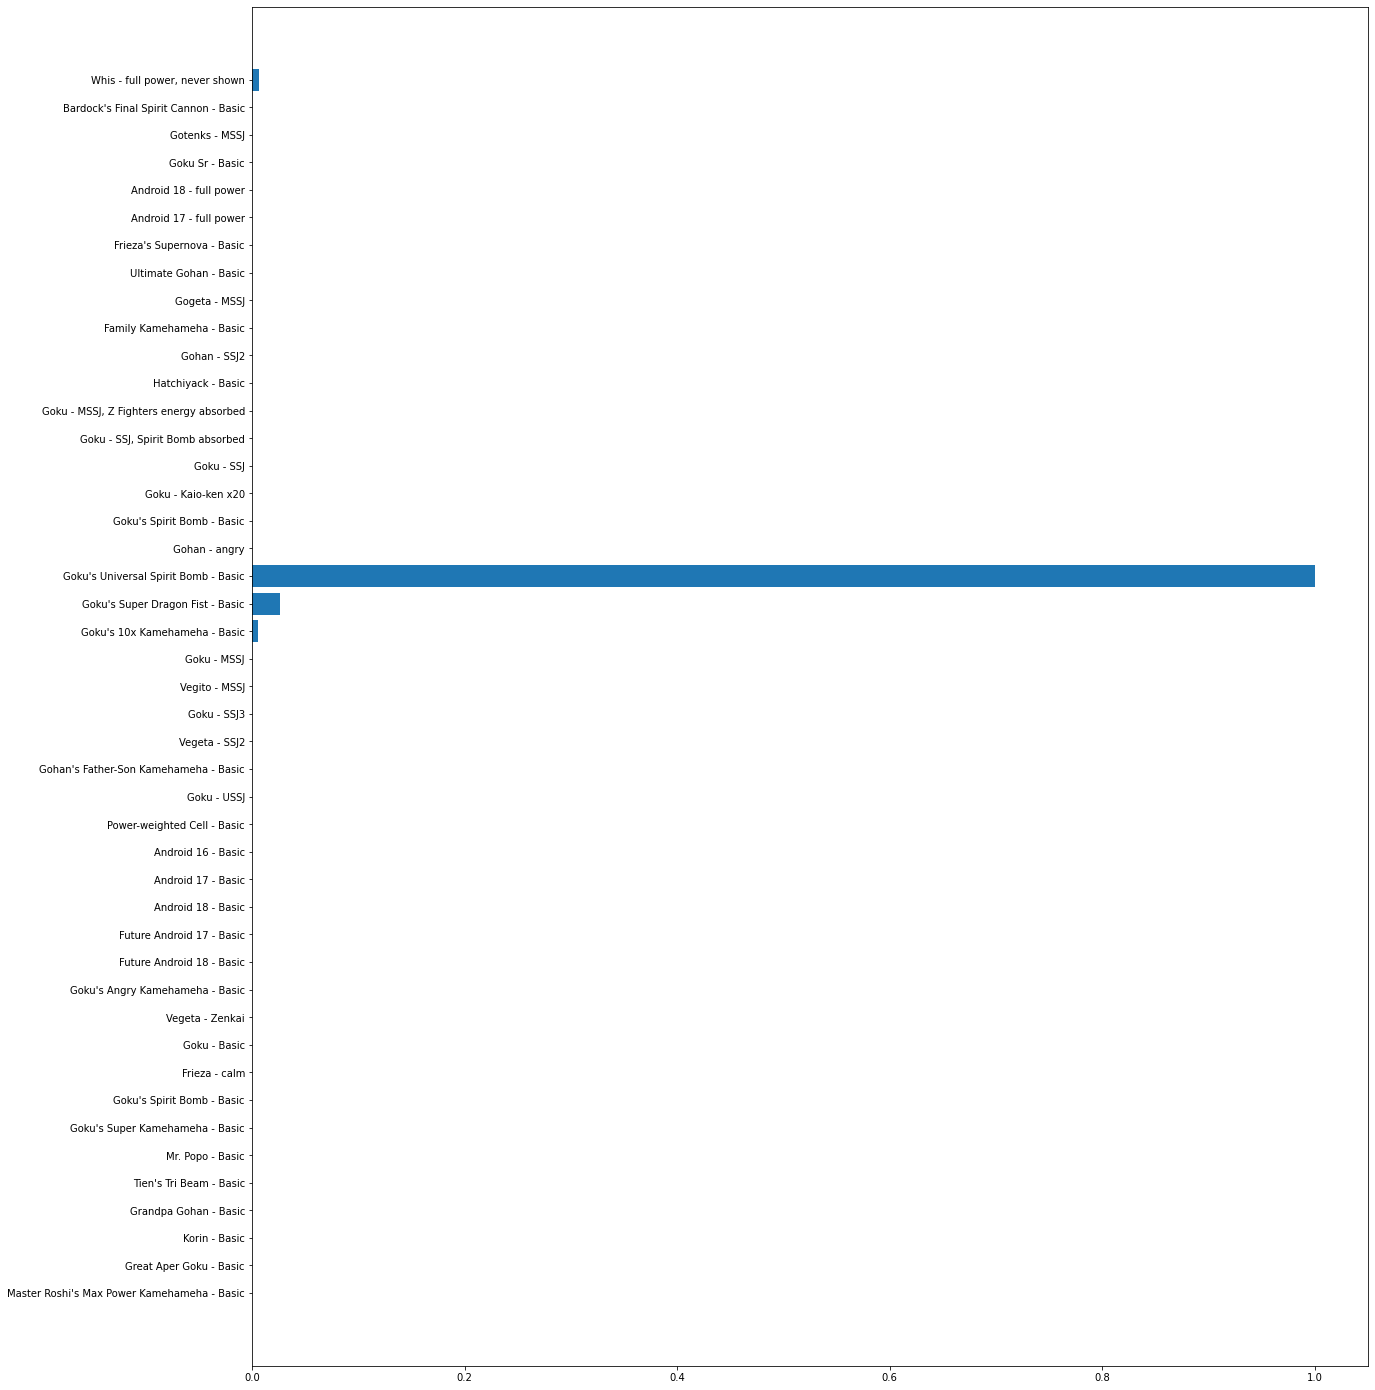

In [70]:
plt.figure(figsize=(20, len(normalized_strongest['Name']) / 2))
plt.barh(normalized_strongest['Name'] + " - " + normalized_strongest['Form'], normalized_strongest['Power Level'])

plt.show()

Lets visualize all of the fighters' power levels who are canon and in basic form. We can use the non normalized data.

####Strongest canon fighers in basic form
Lets see who is the strongest fighter in "basic" form

In [61]:
strongest_canon = strongest.loc[strongest['Canon'] == True]
strongest_canon = strongest_canon[strongest_canon['Form'] == 'Basic']

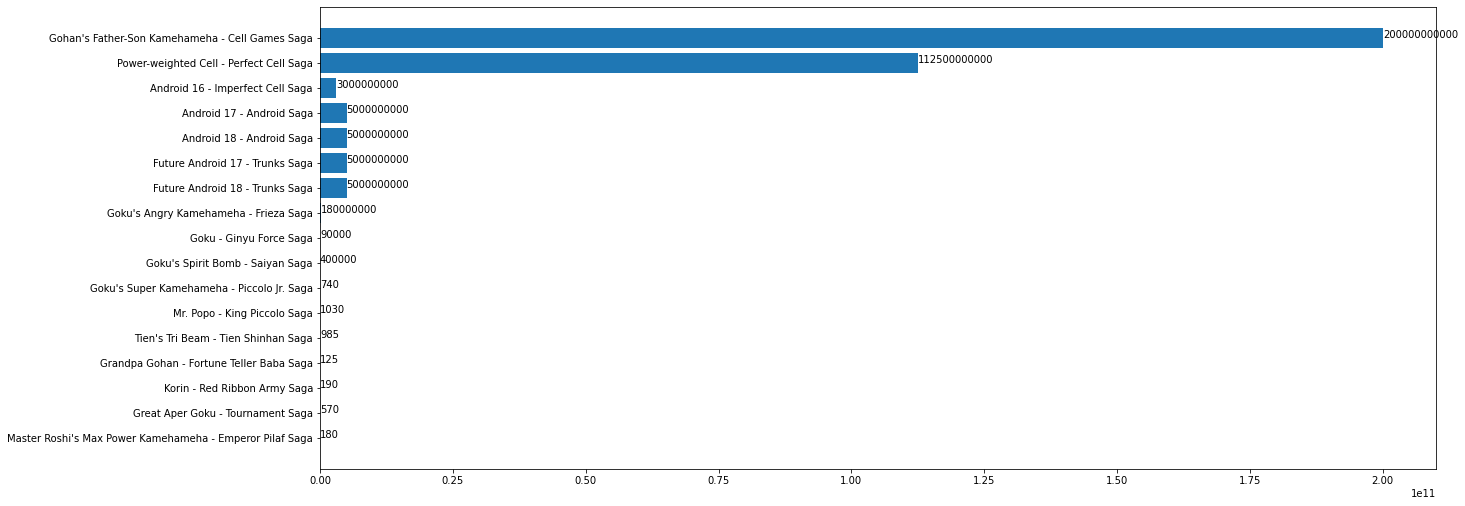

In [64]:
plt.figure(figsize=(20, len(strongest_canon['Name']) / 2))
plt.barh(strongest_canon['Name'] + " - " + strongest_canon['Saga / Movie'], strongest_canon['Power Level'])

for index, value in enumerate(strongest_canon['Power Level']):
  plt.text(value, index, str(value))

plt.show()

##Goku vs Vegeta Power Level
Lets see if Goku or Vegeta has a higher Power Level - **CANON**

In [110]:
# Get Goku's data
goku = data.loc[data['Name'].str.contains("Goku")]
goku = goku.loc[goku['Canon'] == True]
goku = goku.loc[goku['Power Level'] == goku['Power Level']. max()]
goku

,Name,Form,Power Level,Saga / Movie,Series,Canon
544,Goku,SSJ3,11200000000000,Kid Buu Saga,Dragon Ball Z,True


In [111]:
# Get Vegeta's data
vegeta = data.loc[data['Name'].str.contains("Vegeta")]
vegeta = vegeta.loc[vegeta['Canon'] == True]
vegeta = vegeta.loc[vegeta['Power Level'] == vegeta['Power Level']. max()]
vegeta

,Name,Form,Power Level,Saga / Movie,Series,Canon
549,Vegeta,SSJ2,2800000000000,Kid Buu Saga,Dragon Ball Z,True


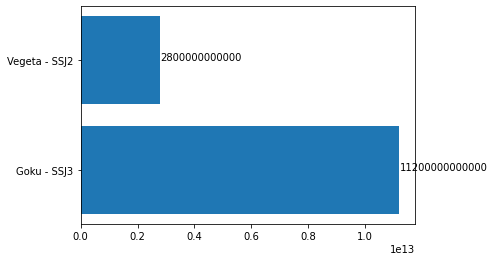

In [112]:
# Compare Goku and Vegeta's power levels
power = pd.concat([goku, vegeta])

plt.barh(power['Name'] + " - " + power['Form'], power['Power Level'])

for index, value in enumerate(power['Power Level']):
  plt.text(value, index, str(value))

plt.show()

Lets compare their power levels to Vegito (fusion between Goku and Vegeta by the use of the Potara Earrings)

In [115]:
# Get Vegito's data
vegito = data.loc[data['Name'].str.contains("Vegito")]
vegito = vegito.loc[vegito['Canon'] == True]
vegito = vegito.loc[vegito['Power Level'] == vegito['Power Level']. max()]
vegito

,Name,Form,Power Level,Saga / Movie,Series,Canon
511,Vegito,MSSJ,28000000000000,Fusion Saga,Dragon Ball Z,True


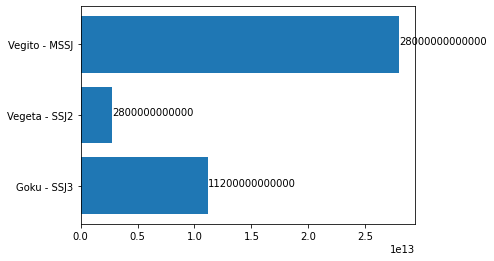

In [117]:
# Compare Goku, Vegeta and Vegito's power levels
power = pd.concat([goku, vegeta, vegito])

plt.barh(power['Name'] + " - " + power['Form'], power['Power Level'])

for index, value in enumerate(power['Power Level']):
  plt.text(value, index, str(value))

plt.show()